# Base model for comparison

- Trust score as Y at employee level

- Demog and pay as features 

- Results: R2 0.03

In [11]:
# LOAD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from sklearn import preprocessing as pp 
from scipy.stats import pearsonr
import plotly.express as px
from factor_analyzer import FactorAnalyzer
from scipy.stats import pearsonr 
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

from scipy.stats import wilcoxon

In [12]:
# setting working Directory
os.chdir("/Users/Ulkar/Google Drive/DATA SCIENCE/Insight Project/Data")
current_path = os.getcwd()
print(current_path)

/Users/Ulkar/Google Drive/DATA SCIENCE/Insight Project/Data


In [13]:
## Load All data
data_all3=pd.read_csv('data_all3__dataprep2.csv')
x_demog=pd.read_csv('x_demog_dataprep2.csv')

/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,76,81,83,86,150) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# PART 1. Creating Y variable

In [14]:
data_all3['TI score']=(pd.to_numeric(data_all3['TI score'], errors='coerce'))

## Trust score is very skewed.  flip and log transform

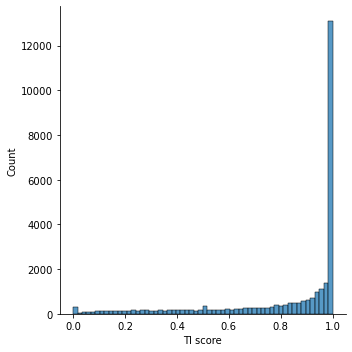

In [15]:
sb.displot(data_all3['TI score'])

In [16]:
## FILL in missing values in trust score with median (very skewed)
data_all3['TI score'].fillna(data_all3['TI score'].median(), inplace=True)

In [17]:
## Flip and take log
data_all3['TI_flip']=1.1-data_all3['TI score']
data_all3['TI_flip_log']=np.log(data_all3['TI_flip'])


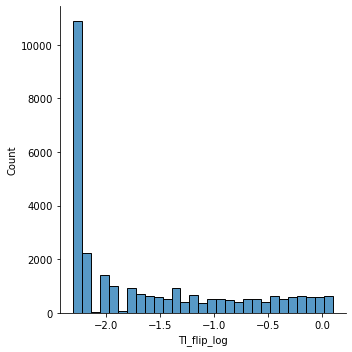

In [18]:
## Check the distribution again
sb.displot(data_all3['TI_flip_log'])

In [19]:
# Transformation squareroot
data_all3['TI_flip_sqrt']=np.sqrt(data_all3['TI_flip'])

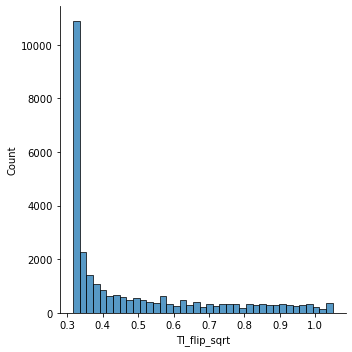

In [20]:
# Plot new TI score
sb.displot(data_all3['TI_flip_sqrt'])

In [44]:
## Trying another approach to normalize data
from scipy import stats
trust=data_all3['TI score'].values+0.01
trust_t= stats.boxcox(trust)

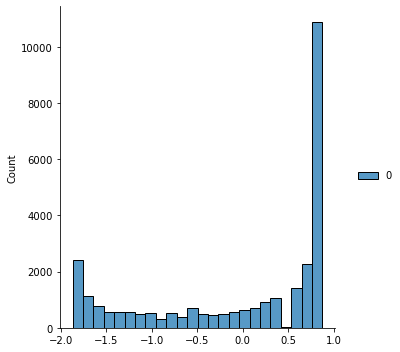

In [48]:
sb.displot(trust_t2)

In [46]:
trust=trust.reshape(-1, 1)

In [47]:
## Try one more transformation
from sklearn.preprocessing import power_transform
trust_t2=power_transform(trust, method='yeo-johnson')

In [52]:
## Try Min-Max scaling the heavily skewed variable before doing a logit transform.
from sklearn.preprocessing import RobustScaler
sc = RobustScaler()

data_all3['trust_sc']=sc.fit_transform(data_all3['TI score'].values.reshape(-1,1))

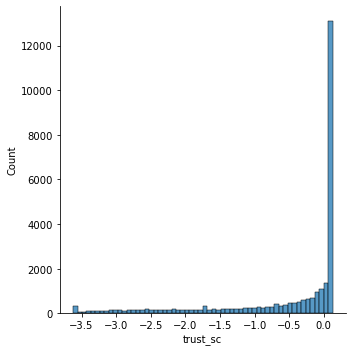

In [53]:
sb.displot(data_all3['trust_sc'])

In [ ]:
## All transformation failed to fix skewness. USE random forest

# Part2:  Create Manager level demographic variables dataset

In [106]:
mng_demog=data_all3[["ManagerID", "Survey_no", "state_id", "Status_m", "Work Status_m", 
                     "Female_m","Age_m",  "tenure_logged", 'tenure_logged_ths', "CurrentPay_m", ]]

mng_demog_df=pd.DataFrame(mng_demog)
mng_demog_df.reset_index(inplace=True)

#mng_demog_df.to_csv("manager_demog.csv", index=False)

## Check distribution of Manager level demographics

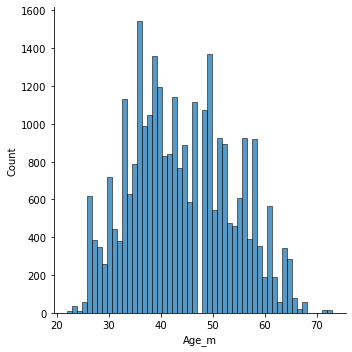

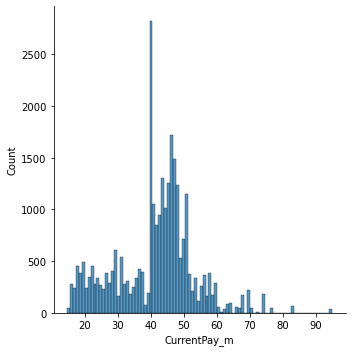

In [107]:
sb.displot(mng_demog_df['Age_m'])  # Age is normally distributed. 
sb.displot(mng_demog_df['CurrentPay_m'])   # log transform needed

## SCALE Manager Level Demographics

In [108]:
## All the necessary variables are created.
mng_demog_df['CurrentPay_logged']=np.log(mng_demog_df['CurrentPay_m'])

# 1. Scale Manager Level Demographic data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
mng_demog_df['CurrentPay_logged']=sc.fit_transform(mng_demog_df['CurrentPay_logged'].values.reshape(-1,1))
mng_demog_df['tenure_logged']=sc.fit_transform(mng_demog_df['tenure_logged'].values.reshape(-1,1))
mng_demog_df['tenure_logged_ths']=sc.fit_transform(mng_demog_df['tenure_logged_ths'].values.reshape(-1,1))
mng_demog_df['Age_m']=sc.fit_transform(mng_demog_df['Age_m'].values.reshape(-1,1))


  ## Encodong categorial variables
mng_demog_df=pd.get_dummies(mng_demog_df, columns=["Status_m", "Work Status_m", "state_id" ], 
                            prefix=[ 'status', 'ws', 'state'], drop_first=True)
 ## Mean Encode Race.
from category_encoders import TargetEncoder
xx_r=data_all3[['Race_m']]
yy_r=data_all3[['TI score']]
 
mean_ec = TargetEncoder(cols=['Race_m'])
Race_ec=mean_ec.fit_transform(xx_r, yy_r)



/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [109]:
Race_ec=Race_ec.reset_index(drop=True)

In [110]:
## MERGING ALL INTO ONE FILE

manag_x=pd.concat([mng_demog_df, Race_ec], axis=1)  # with target encoding

In [111]:
manag_x=manag_x.iloc[:, 1:]


In [112]:
manag_x=manag_x.drop(["CurrentPay_m"], axis=1) 

In [147]:
manag_x2=manag_x.iloc[:, 2:]
manag_x2.head(5)

,Female_m,Age_m,tenure_logged,tenure_logged_ths,CurrentPay_logged,status_D,status_L,status_P,status_T,ws_P,state_IL,state_IN,state_KY,state_MA,state_MI,state_NM,state_OH,state_PA,state_TN,Race_m
0,0,2.147901,-0.715395,0.047830,0.039322,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.820589
1,0,0.511262,-0.169288,0.755480,0.039322,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.820589
2,1,0.818132,-0.893315,1.560868,0.039322,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.820589
3,0,0.511262,1.531605,1.176384,0.039322,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.830426
4,1,-0.613928,-3.140315,-4.244982,0.039322,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.796752


# RANDOM FOREST MODEL

<ipython-input-165-9a427a0f279e>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


Feature: 0, Score: 0.02466
Feature: 1, Score: 0.13381
Feature: 2, Score: 0.17459
Feature: 3, Score: 0.22136
Feature: 4, Score: 0.28841
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00110
Feature: 7, Score: 0.00185
Feature: 8, Score: 0.02773
Feature: 9, Score: 0.00045
Feature: 10, Score: 0.00004
Feature: 11, Score: 0.03469
Feature: 12, Score: 0.04395
Feature: 13, Score: 0.00290
Feature: 14, Score: 0.01124
Feature: 15, Score: 0.00003
Feature: 16, Score: 0.01299
Feature: 17, Score: 0.00080
Feature: 18, Score: 0.00074
Feature: 19, Score: 0.01866


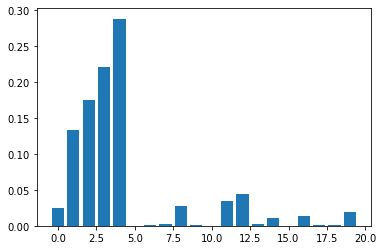

0.1456999997673285

In [165]:


## RUN RANDOM FOREST

# decision tree for feature importance on a regression problem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(manag_x2, trust_t2, test_size = 0.2, random_state = 0)


# define the model
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)


# fit the model
regressor.fit(X_train, y_train)

# get importance
importance = regressor.feature_importances_

#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

y_pred = regressor.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

# PART 3: REGRESSION

## RUN LASSO FOR FEATURE SELECTION

In [85]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [151]:

xCV = manag_x2
yCV = trust_t2



x_lasso =  manag_x2
y_lasso = trust_t2

train_number = 10000


# before loop
test_r_squared = np.zeros((train_number,1))
train_r_squared = np.zeros((train_number,1))
lasso_alpha = np.zeros((train_number,1))
lasso_coef = np.zeros((train_number, x_lasso.shape[1]))


for trialNo in range(train_number):
    
    #SAMPLE SPLIT: 75-25
    x_lasso_train, x_lasso_test, y_lasso_train, y_lasso_test = train_test_split(x_lasso, y_lasso, test_size=0.25)

    reg = LassoCV(cv=5).fit(x_lasso_train, y_lasso_train)

    YpredLasso = reg.predict(x_lasso_test)
    YpredLasso_train = reg.predict(x_lasso_train)
    
    test_r_squared[trialNo] = r2_score(y_lasso_test, YpredLasso)
    train_r_squared[trialNo] = r2_score(y_lasso_train, YpredLasso_train)
    lasso_coef[trialNo,:] = reg.coef_ 



/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Ulkar/opt/anaconda3/envs/insight/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


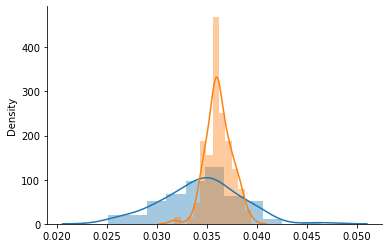

In [152]:
#Distribution of R-squared for test and train set
test_r_squared_df=pd.DataFrame(data=test_r_squared)
test_r_squared_df.rename(columns = {0:'coefficient of determination'}, inplace = True) 

train_r_squared_df=pd.DataFrame(data=train_r_squared)
train_r_squared_df.rename(columns = {0:'coefficient of determination_train'}, inplace = True) 

sb.distplot(test_r_squared_df)
sb.despine()
sb.distplot(train_r_squared_df)
sb.despine()

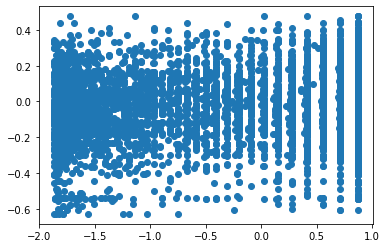

In [153]:
plt.scatter(YCV_test, YpredLassoCV)

### Check top features

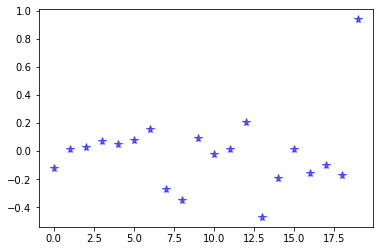

In [154]:
lasso_coef_df = pd.DataFrame(data=lasso_coef)

mean_coef=lasso_coef_df.mean()

plt.plot(mean_coef,alpha=0.6,linestyle='none',marker='*',markersize=8,color='blue') 

In [155]:
abs_mean_coef=abs(mean_coef)
top_coef=abs_mean_coef.sort_values(ascending=False)
top_coef.index

Int64Index([19, 13, 8, 7, 12, 14, 18, 16, 6, 0, 17, 9, 5, 3, 4, 2, 10, 11, 15,
            1],
           dtype='int64')

## RUN REGRESSION WITH TOP FEATURES

In [167]:
#Choose top 10 features.

all_x  = manag_x2


features_number = 10
#get the top n features
top_coef=abs_mean_coef.sort_values(ascending=False)

lasso10_features = all_x.iloc[:,top_coef.index[0]]

for features in range(features_number-1):
    lasso10_features = pd.concat([lasso10_features, all_x.iloc[:,top_coef.index[features+1]]], axis = 1)

    
x_linear = lasso10_features
y_linear = y

train_number = 10000

#initialize
linear_r_squared = np.zeros((train_number,1))
linear_r_squared_train = np.zeros((train_number,1))
linear_coef = np.zeros((train_number,x_linear.shape[1]))

for trialNo in range(train_number):
    
    #split Test and Train set 0.25 %
    xlin_train, xlin_test, ylin_train, ylin_test = train_test_split(x_linear, y_linear, test_size=0.25)
    
    linear_reg = linear_model.LinearRegression()
    
    model = linear_reg.fit(xlin_train, ylin_train)
    
    Ypred_lin_train = linear_reg.predict(xlin_train)
    Ypred_lin = linear_reg.predict(xlin_test)
    
    linear_r_squared_train[trialNo] = r2_score(ylin_train, Ypred_lin_train)
    linear_r_squared[trialNo] = r2_score(ylin_test, Ypred_lin)
    linear_coef[trialNo,:] = linear_reg.coef_

In [ ]:
#Distribution of R-squared
r2_df=pd.DataFrame(data=linear_r_squared)
r2_df.rename(columns = {0:'coefficient of determination'}, inplace = True) 

r2_df_train=pd.DataFrame(data=linear_r_squared_train)
r2_df_train.rename(columns = {0:'coefficient of determination_train'}, inplace = True) 

#sb.distplot(r2_df_train)
#sb.despine()
sb.distplot(r2_df)
sb.despine()

In [158]:
r2=linear_r_squared.mean()
print(r2)

0.02376697050655691


### PLOT PREDICTION AGAINS ACTUAL VALUES

Text(0, 0.5, 'Observed Values')

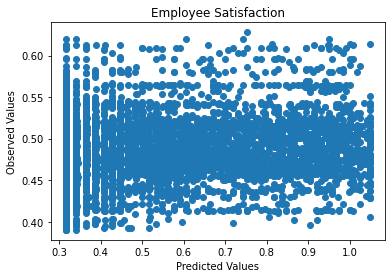

In [121]:
plt.scatter(Yl_test, Ypredl)
plt.title("Employee Satisfaction")

plt.xlabel("Predicted Values")
plt.ylabel("Observed Values")

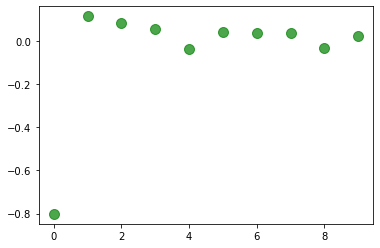

In [159]:
#Average weight of the coefficient for each feature
linear_coef_df = pd.DataFrame(data=linear_coef)

mean_linear_coef=linear_coef_df.mean()

plt.plot(mean_linear_coef,alpha=0.7,linestyle='none',marker='o',markersize=10,color='green') 

In [160]:
abs_mean_coef=(mean_linear_coef)
top_coef=abs_mean_coef.sort_values(ascending=False)
top_coef


1    0.113059
2    0.081191
3    0.053303
5    0.040571
7    0.037033
6    0.034166
9    0.023341
8   -0.035091
4   -0.037944
0   -0.801410
dtype: float64

In [161]:
mean_linear_coef

0   -0.801410
1    0.113059
2    0.081191
3    0.053303
4   -0.037944
5    0.040571
6    0.034166
7    0.037033
8   -0.035091
9    0.023341
dtype: float64